參考資料：
1. AE in keras: https://blog.keras.io/building-autoencoders-in-keras.html
- Autoencoder 自编码:https://morvanzhou.github.io/tutorials/machine-learning/keras/2-6-autoencoder/
- https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/
- http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_psnr
- http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim

In [1]:
# 時間計算
import time 
# 數值運算
import numpy as np
# 圖片輸出用
from matplotlib import pyplot as plt
from cv2 import imwrite 
# 結果運算用
from skimage.measure import compare_psnr, compare_ssim 

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
# from keras.models import load_model

E:\Anaconda3\envs\TF-Ke\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
_startTime = time.time()

##### 函數 - 測試用

In [4]:
def CheckType(intVar):
    print("max:",   intVar.max())
    print("min:",   intVar.min())
    print("shape:", intVar.shape)
    print("type:",  intVar.dtype)
    return

##### 函數 - 輸出用

In [5]:
def ResultImgShow(inputImg, modelName, strImgLabel = "TMP"):
    # 輸出參數設置
    img_amount = inputImg.shape[0]
    cols_output = 50
    rows_output = img_amount // cols_output
#     # 改變大小用，但這裡有確切大小所以不必處理
#     if rows_output < 3:
#         cols_output = 10
#         rows_output = img_amount // cols_output
#         if rows_output < 3:
#             cols_output = 5
#             rows_output = img_amount // cols_output
    if rows_output > cols_output:
        rows_output = cols_output
    # 輸出設置 - 水平堆疊再垂直堆疊
    ## v - 初始
    img_h = inputImg[0]
    for i in range(1, cols_output):
        img_tmp = inputImg[i]
        img_h = np.hstack((img_h, img_tmp))
    img_v = img_h.copy()
    ## v - Loop
    for j in range(1, rows_output):
        ## h - 初始
        img_h = inputImg[j * cols_output]
        ## h - Loop
        for i in range(1, cols_output):
            img_tmp = inputImg[j * cols_output + i]
            img_h = np.hstack((img_h, img_tmp))
        img_v = np.vstack((img_v, img_h))
    # 顯示 與 存取
    imwrite(modelName.split(".")[0] +"_"+ strImgLabel+ ".png", img_v)
    plt.imshow(img_v, cmap = "gray")
#     plt.savefig(model_name.split(".")[0] +"_"+ strImgLabel+ ".png")
    plt.show()
    plt.close()
    return

###### 函數 - 計算誤差

In [6]:
def PSNR_ALL(testData, truthData, strImgLabel = "TMP", boolTest = False):
    psnrSum_test = 0
    for i in range(testData.shape[0]):
        groundTruth   = truthData[i, :,:]
        predictResult = testData[i, :,:]
        psnrTmp = float(compare_psnr(groundTruth, predictResult))
        psnrSum_test += psnrTmp
    psnrSum_test /= testData.shape[0]
    print(strImgLabel, "PSNR:", psnrSum_test)
    return psnrSum_test

In [7]:
def SSIM_ALL(testData, truthData, strImgLabel = "TMP", boolTest = False):
    ssimSum_test = 0
    for i in range(testData.shape[0]):
        groundTruth   = truthData[i, :,:]
        predictResult = testData[i, :,:]
        ssimTmp = float(compare_ssim(groundTruth, predictResult))
        ssimSum_test += ssimTmp
    ssimSum_test /= testData.shape[0]
    print(strImgLabel, "SSIM:", ssimSum_test)
    return ssimSum_test

###### 函數 - 預處理與後處理

In [8]:
def DataPreProcess(inputData, img_rows = 28, img_cols = 28):
    outputData = inputData.reshape(inputData.shape[0], img_rows * img_cols)
    outputData = outputData.astype('float32') /255 -0.5
    outputData *= 2
    return outputData

In [9]:
def DataRecovery(inputData, img_rows = 28, img_cols = 28):
    outputData = ((inputData /2)+0.5) * 255
    outputData = outputData.reshape((outputData.shape[0], img_rows, img_cols))
    outputData = outputData.astype('uint8')
    return outputData

In [10]:
def PredictFlow(inputData, model, boolPredict = True):
    # 預處理
    inputData = DataPreProcess(inputData)
    if boolPredict:
        decodeImg = autoencoder_complex.predict(inputData)
        decodeImg = DataRecovery(decodeImg)
    else:
        decodeImg = DataRecovery(inputData)
    return decodeImg

# 主程式

#### 參數設置

In [11]:
outputFolder = "output121223_symmetry/" # 不再偵測存在與否

In [12]:
batch_size = 128
# num_classes = 10
epochs = 500
# input image dimensions
img_rows, img_cols = 28, 28

##### 讀取訓練資料
- 利用完整沒雜訊的資料進行訓練 。
- 只取用圖像，不取標籤。

In [13]:
dataSetName_org = "mnist.npz"
f = np.load(dataSetName_org)
x_train_org, x_test_org = f['x_train'], f['x_test']
del f

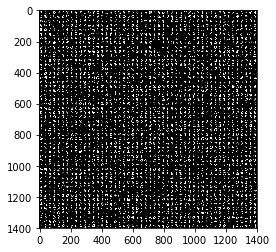

In [14]:
ResultImgShow(x_test_org, outputFolder + "CLEAR-IN", strImgLabel = "ORIGIN")

In [15]:
x_train_org = DataPreProcess(x_train_org)
print(x_train_org.shape[0], 'train samples', "in", x_train_org.shape)

60000 train samples in (60000, 784)


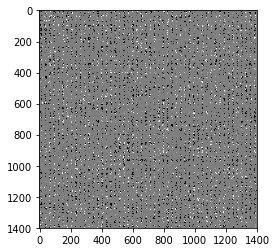

In [16]:
# 先將處理過的原資料，輸出
_x_test_org = DataRecovery(x_test_org)
ResultImgShow(_x_test_org, outputFolder + "PROCESSED", strImgLabel = "ORIGIN")
del _x_test_org

###### 讀取測試資料
- 由完整的資料集訓練，得到完整特性

In [17]:
dataSetName_noise = "mnist-pria-awgn_snr=10.npz"
f = np.load(dataSetName_noise)
x_train_noise, x_test_noise = f['x_train'], f['x_test']
del f

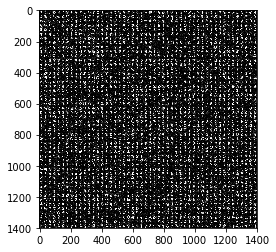

In [18]:
ResultImgShow(x_test_noise, outputFolder + "CLEAR-IN", strImgLabel = "BEFORE")

In [19]:
# 預處理
x_test_noise = DataPreProcess(x_test_noise)

## 模組架設 - 複雜版

In [20]:
# ## 法 1
# autoencoder = Sequential()
# autoencoder.add(Dense(1500, activation='relu', input_shape=(784,)))
# autoencoder.add(Dense(375, activation='relu')) 
# autoencoder.add(Dense(50)) 

# autoencoder.add(Dense(375, activation='relu')) 
# autoencoder.add(Dense(1500, activation='relu')) 
# autoencoder.add(Dense(784, activation='tanh')) 

In [21]:
## 法 2 - 比較有效率(?)
input_img = Input(shape=(784,))
# encoder layers
encoded = Dense(1500, activation='relu')(input_img)
encoded = Dense(375, activation='relu')(encoded)
encoder_output = Dense(50)(encoded)
# decoder layers
decoded = Dense(375, activation='relu')(encoder_output)
decoded = Dense(1500, activation='relu')(decoded)
decoded = Dense(784, activation='tanh')(decoded)
# construct the autoencoder model
autoencoder_complex = Model(input=input_img, output=decoded)

E:\Anaconda3\envs\TF-Ke\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


#### 模組 - 簡介

In [22]:
autoencoder_complex.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              1177500   
_________________________________________________________________
dense_2 (Dense)              (None, 375)               562875    
_________________________________________________________________
dense_3 (Dense)              (None, 50)                18800     
_________________________________________________________________
dense_4 (Dense)              (None, 375)               19125     
_________________________________________________________________
dense_5 (Dense)              (None, 1500)              564000    
_________________________________________________________________
dense_6 (Dense)              (None, 784)               1176784   
Total para

#### 模組 - 架設

In [23]:
autoencoder_complex.compile(optimizer='adam', loss='mse')

#### 模組 - 訓練
用完整圖片訓練，完整圖片比對

In [ ]:
history_complex = autoencoder_complex.fit(x_train_org, x_train_org, # 訓練資料、結果比對資料
                    batch_size=batch_size, #
                    epochs=epochs)

Epoch 1/500
60000/60000 [==============================] - 8s 134us/step - loss: 0.0794
Epoch 2/500
60000/60000 [==============================] - 7s 111us/step - loss: 0.0312
Epoch 3/500
60000/60000 [==============================] - 6s 103us/step - loss: 0.0244
Epoch 4/500
60000/60000 [==============================] - 6s 107us/step - loss: 0.0212
Epoch 5/500
60000/60000 [==============================] - 7s 109us/step - loss: 0.0192
Epoch 6/500
60000/60000 [==============================] - 15s 243us/step - loss: 0.0177
Epoch 7/500
60000/60000 [==============================] - 9s 150us/step - loss: 0.0168
Epoch 8/500
60000/60000 [==============================] - 15s 242us/step - loss: 0.0160
Epoch 9/500
60000/60000 [==============================] - 8s 128us/step - loss: 0.0153
Epoch 10/500
60000/60000 [==============================] - 14s 235us/step - loss: 0.0148
Epoch 11/500
60000/60000 [==============================] - 9s 144us/step - loss: 0.0144
Epoch 12/500
60000/60000 [=

#### 模組 - 儲存

In [ ]:
model_name_complex = outputFolder + "model_complex"+"e"+str(epochs)+"_b"+str(batch_size) + \
                    ".h5"
#                     "_" + "-".join([str(i) for i in time.localtime()[0:5]]) +\

In [ ]:
autoencoder_complex.save(model_name_complex)

#### 模組 - 使用與輸出

In [ ]:
decodeImg_test = autoencoder_complex.predict(x_test_noise)
decodeImg_test = DataRecovery(decodeImg_test)

In [ ]:
# decodeImg_test = PredictFlow(x_test_noise, decodeImg_test, boolPredict = True)

In [ ]:
ResultImgShow(decodeImg_test, model_name_complex, strImgLabel = "AFTER");

### 計算結果 - 複雜版

In [ ]:
PSNR_ALL(decodeImg_test, x_test_org, strImgLabel = "TEST");
SSIM_ALL(decodeImg_test, x_test_org, strImgLabel = "TEST");

###### 清除

In [ ]:
del autoencoder_complex
del decodeImg_test

###### 運行時間

In [ ]:
_midTime = time.time()
print("It cost", _midTime - _startTime, "sec.")

## 模組架設 - 簡單版

In [ ]:
## 法 2 - 比較有效率
input_img = Input(shape=(784,))
# encoder layers
encoder_output = Dense(50)(input_img)
# decoder layers
decoded = Dense(784, activation='tanh')(encoder_output)
# construct the autoencoder model
autoencoder_simple = Model(input=input_img, output=decoded)

#### 模組 - 簡介

In [ ]:
autoencoder_simple.summary()

#### 模組 - 架設

In [ ]:
autoencoder_simple.compile(optimizer='adam', loss='mse')

#### 模組 - 訓練
用完整圖片訓練，完整圖片比對

In [ ]:
history_simple = autoencoder_simple.fit(x_train_org, x_train_org, # 訓練資料、結果比對資料
                    batch_size=batch_size, #
                    epochs=epochs)

#### 模組 - 儲存

In [ ]:
model_name_simple = outputFolder + "model_simple"+"e"+str(epochs)+"_b"+str(batch_size) + \
                    ".h5"
#                     "_" + "-".join([str(i) for i in time.localtime()[0:5]]) +\

In [ ]:
autoencoder_simple.save(model_name_simple)

#### 模組 - 使用與輸出

In [ ]:
decodeImg_test_simple = autoencoder_simple.predict(x_test_noise)
decodeImg_test_simple = DataRecovery(decodeImg_test_simple)

In [ ]:
ResultImgShow(decodeImg_test_simple, model_name_simple, strImgLabel = "AFTER")

### 計算結果 - 簡單版

In [ ]:
PSNR_ALL(decodeImg_test_simple, x_train_org, strImgLabel = "TEST");
SSIM_ALL(decodeImg_test_simple, x_train_org, strImgLabel = "TEST");

###### 清除

In [ ]:
del autoencoder_simple
del decodeImg_test

###### 運行時間

In [ ]:
_endTime = time.time()
print("It cost", _endTime - _midTime, "sec.")

In [ ]:
print("Total cost", _endTime - _startTime, "sec.")